## Introduction

The primary goal of this notebook is to clean and prepare the Redfin ZIP Code Market Tracker dataset for a rigorous analysis aimed at identifying the best ZIP codes for first‐time home buyers. We will:

1. Parse and index quarterly date fields for time‐series operations  
2. Enforce consistent five‐digit ZIP code formatting  
3. Identify and remove duplicate records  
4. Audit and impute missing values using threshold‐based dropping, time‐based interpolation, and median fills  
5. Screen and winsorize outliers on key market metrics (sale price, days on market, inventory)  
6. Perform basic sanity checks to validate trends and sample robustness  

By completing these steps, we will produce a high‐quality, gap‐free dataset that accurately reflects market dynamics and supports reliable exploratory analysis and predictive modeling.


In [1]:
# Import libraries
import pandas as pd
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
'''
    Load & Prep 
    dataset downloaded from: 
    https://redfin-public-data.s3.us-west-2.amazonaws.com/redfin_market_tracker/zip_code_market_tracker.tsv000.gz
'''

df = pd.read_csv(
    "data/zip_code_market_tracker.tsv000.gz", 
    sep='\t', 
    compression='gzip'
)

In [3]:
# Check first rows of the dataset
pd.set_option('display.max_columns', None)
df.head()

,PERIOD_BEGIN,PERIOD_END,PERIOD_DURATION,REGION_TYPE,REGION_TYPE_ID,TABLE_ID,IS_SEASONALLY_ADJUSTED,REGION,CITY,STATE,STATE_CODE,PROPERTY_TYPE,PROPERTY_TYPE_ID,MEDIAN_SALE_PRICE,MEDIAN_SALE_PRICE_MOM,MEDIAN_SALE_PRICE_YOY,MEDIAN_LIST_PRICE,MEDIAN_LIST_PRICE_MOM,MEDIAN_LIST_PRICE_YOY,MEDIAN_PPSF,MEDIAN_PPSF_MOM,MEDIAN_PPSF_YOY,MEDIAN_LIST_PPSF,MEDIAN_LIST_PPSF_MOM,MEDIAN_LIST_PPSF_YOY,HOMES_SOLD,HOMES_SOLD_MOM,HOMES_SOLD_YOY,PENDING_SALES,PENDING_SALES_MOM,PENDING_SALES_YOY,NEW_LISTINGS,NEW_LISTINGS_MOM,NEW_LISTINGS_YOY,INVENTORY,INVENTORY_MOM,INVENTORY_YOY,MONTHS_OF_SUPPLY,MONTHS_OF_SUPPLY_MOM,MONTHS_OF_SUPPLY_YOY,MEDIAN_DOM,MEDIAN_DOM_MOM,MEDIAN_DOM_YOY,AVG_SALE_TO_LIST,AVG_SALE_TO_LIST_MOM,AVG_SALE_TO_LIST_YOY,SOLD_ABOVE_LIST,SOLD_ABOVE_LIST_MOM,SOLD_ABOVE_LIST_YOY,PRICE_DROPS,PRICE_DROPS_MOM,PRICE_DROPS_YOY,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,PARENT_METRO_REGION,PARENT_METRO_REGION_METRO_CODE,LAST_UPDATED
0,2019-05-01,2019-07-31,90,zip code,2,38165,False,Zip Code: 92173,NaN,California,CA,Multi-Family (2-4 Unit),4,655500.0,0.077239,0.197260,600000.0,-0.157895,-0.555556,310.091743,-0.176327,0.673646,302.752294,0.052174,-0.342467,3.0,0.500000,2.000000,2.0,0.000000,NaN,3.0,0.500000,0.500000,2.0,1.000000,0.000000,NaN,NaN,NaN,27.0,-51.5,-42.0,1.041624,0.025438,0.044356,1.000000,0.000000,1.000000,NaN,NaN,NaN,0.500000,0.00000,NaN,"San Diego, CA",41740,2025-06-16 14:45:18.190 Z
1,2023-01-01,2023-03-31,90,zip code,2,26504,False,Zip Code: 61523,NaN,Illinois,IL,Single Family Residential,6,169000.0,0.011976,0.229091,179900.0,0.000000,0.565709,90.167454,-0.011498,0.025614,104.651163,0.054884,0.255989,25.0,-0.074074,-0.137931,29.0,0.318182,0.000000,25.0,0.190476,0.470588,12.0,0.090909,-0.294118,NaN,NaN,NaN,32.5,7.5,-48.5,0.967367,-0.011181,-0.021441,0.120000,-0.102222,-0.121379,NaN,NaN,NaN,0.275862,-0.04232,0.241379,"Peoria, IL",37900,2025-06-16 14:45:18.190 Z
2,2015-09-01,2015-11-30,90,zip code,2,13440,False,Zip Code: 32207,NaN,Florida,FL,Multi-Family (2-4 Unit),4,59000.0,-0.432692,-0.796552,NaN,NaN,NaN,76.129032,-0.070621,-0.029749,NaN,NaN,NaN,1.0,-0.500000,0.000000,3.0,0.000000,2.000000,NaN,NaN,NaN,1.0,0.000000,NaN,NaN,NaN,NaN,75.0,31.5,-252.0,0.907692,-0.043152,-0.058974,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.00000,0.000000,"Jacksonville, FL",27260,2025-06-16 14:45:18.190 Z
3,2020-01-01,2020-03-31,90,zip code,2,10621,False,Zip Code: 26501,NaN,West Virginia,WV,Townhouse,13,185000.0,-0.028871,0.097923,208112.5,-0.051663,0.124932,110.451949,-0.164439,0.117144,113.525048,0.000000,0.013580,8.0,0.000000,3.000000,8.0,0.000000,3.000000,12.0,0.500000,0.090909,16.0,0.142857,0.000000,NaN,NaN,NaN,237.5,80.5,185.5,0.984259,0.002674,0.038150,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.00000,0.000000,"Morgantown, WV",34060,2025-06-16 14:45:18.190 Z
4,2016-12-01,2017-02-28,90,zip code,2,12141,False,Zip Code: 29569,NaN,South Carolina,SC,All Residential,-1,148857.5,0.004335,0.103466,145900.0,0.009727,-0.049202,98.707710,-0.009027,0.198594,95.229839,-0.001100,-0.030866,44.0,0.333333,0.333333,44.0,0.333333,0.333333,57.0,0.140000,0.055556,108.0,-0.018182,0.186813,NaN,NaN,NaN,154.5,-6.5,-23.5,0.971145,0.000952,0.026631,0.159091,0.037879,0.007576,NaN,NaN,NaN,0.000000,0.00000,0.000000,"Myrtle Beach, SC",34820,2025-06-16 14:45:18.190 Z


In [4]:
# Shape
df.shape

(9009340, 58)

In [5]:
# Check all the columns and features
df.columns

Index(['PERIOD_BEGIN', 'PERIOD_END', 'PERIOD_DURATION', 'REGION_TYPE',
       'REGION_TYPE_ID', 'TABLE_ID', 'IS_SEASONALLY_ADJUSTED', 'REGION',
       'CITY', 'STATE', 'STATE_CODE', 'PROPERTY_TYPE', 'PROPERTY_TYPE_ID',
       'MEDIAN_SALE_PRICE', 'MEDIAN_SALE_PRICE_MOM', 'MEDIAN_SALE_PRICE_YOY',
       'MEDIAN_LIST_PRICE', 'MEDIAN_LIST_PRICE_MOM', 'MEDIAN_LIST_PRICE_YOY',
       'MEDIAN_PPSF', 'MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF',
       'MEDIAN_LIST_PPSF_MOM', 'MEDIAN_LIST_PPSF_YOY', 'HOMES_SOLD',
       'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES',
       'PENDING_SALES_MOM', 'PENDING_SALES_YOY', 'NEW_LISTINGS',
       'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'INVENTORY', 'INVENTORY_MOM',
       'INVENTORY_YOY', 'MONTHS_OF_SUPPLY', 'MONTHS_OF_SUPPLY_MOM',
       'MONTHS_OF_SUPPLY_YOY', 'MEDIAN_DOM', 'MEDIAN_DOM_MOM',
       'MEDIAN_DOM_YOY', 'AVG_SALE_TO_LIST', 'AVG_SALE_TO_LIST_MOM',
       'AVG_SALE_TO_LIST_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM',
 

In [6]:
# Data types for each column
df.dtypes

PERIOD_BEGIN                       object
PERIOD_END                         object
PERIOD_DURATION                     int64
REGION_TYPE                        object
REGION_TYPE_ID                      int64
TABLE_ID                            int64
IS_SEASONALLY_ADJUSTED               bool
REGION                             object
CITY                              float64
STATE                              object
STATE_CODE                         object
PROPERTY_TYPE                      object
PROPERTY_TYPE_ID                    int64
MEDIAN_SALE_PRICE                 float64
MEDIAN_SALE_PRICE_MOM             float64
MEDIAN_SALE_PRICE_YOY             float64
MEDIAN_LIST_PRICE                 float64
MEDIAN_LIST_PRICE_MOM             float64
MEDIAN_LIST_PRICE_YOY             float64
MEDIAN_PPSF                       float64
MEDIAN_PPSF_MOM                   float64
MEDIAN_PPSF_YOY                   float64
MEDIAN_LIST_PPSF                  float64
MEDIAN_LIST_PPSF_MOM              

In [7]:
''' Ensure correct types, extract zip code from region and create a new feature ZIP.'''

df["ZIP"] = df["REGION"].str.extract(r"(\d{5})").astype(str)
df["PERIOD_BEGIN"] = pd.to_datetime(df["PERIOD_BEGIN"])
df["PERIOD_END"]   = pd.to_datetime(df["PERIOD_END"])

In [8]:
''' Create Quarters and years columns '''

# 1. Make sure PERIOD_BEGIN is datetime
df['PERIOD_BEGIN'] = pd.to_datetime(df['PERIOD_BEGIN'], format='%Y-%m-%d', errors='raise')

# 2. Convert to a quarterly period and set as index
df['QUARTER_PERIOD'] = df['PERIOD_BEGIN'].dt.to_period('Q')
df = df.set_index('QUARTER_PERIOD')

# 3. Extract year and quarter for any custom grouping
df['YEAR']    = df.index.year
df['QUARTER'] = df.index.quarter

# 4. (Optional) if you prefer a timestamp index at quarter-start:
# df.index = df.index.to_timestamp()

# 5. Quick sanity check
print(df.index.dtype)            # should show period[Q-DEC]
print(df[['YEAR','QUARTER']].head(20))

period[Q-DEC]
                YEAR  QUARTER
QUARTER_PERIOD               
2019Q2          2019        2
2023Q1          2023        1
2015Q3          2015        3
2020Q1          2020        1
2016Q4          2016        4
2017Q1          2017        1
2015Q4          2015        4
2013Q1          2013        1
2012Q2          2012        2
2017Q1          2017        1
2020Q2          2020        2
2019Q1          2019        1
2021Q3          2021        3
2021Q1          2021        1
2024Q4          2024        4
2014Q4          2014        4
2020Q1          2020        1
2017Q1          2017        1
2020Q3          2020        3
2021Q4          2021        4


In [9]:
''' Deal with uniqueness ''' 

# 1. Count exact duplicate rows
n_exact = df.duplicated().sum()
print(f"Exact duplicate rows: {n_exact}")

# 2. Drop exact duplicate rows in place
df = df.drop_duplicates()
print(f"Shape after dropping exact duplicates: {df.shape}")

# 3. Now check for duplicate (zipcode, period) entries
#    — if you set `quarter_period` as your index, reset it first:
df = df.reset_index()  # brings quarter_period back to a column

# 4. Count duplicates by subset
n_key_dupes = df.duplicated(subset=['ZIP','QUARTER_PERIOD']).sum()
print(f"Duplicate (zipcode, quarter): {n_key_dupes}")

# 5. Drop these, keeping the first occurrence
df = df.drop_duplicates(subset=['ZIP','QUARTER_PERIOD'], keep='first')
print(f"Shape after dropping key duplicates: {df.shape}")

# 6. (Optional) Set your index back if you want
df = df.set_index('QUARTER_PERIOD')


Exact duplicate rows: 0
Shape after dropping exact duplicates: (9009340, 61)
Duplicate (zipcode, quarter): 7939630
Shape after dropping key duplicates: (1069710, 62)


In [10]:
''' Check Housing price metrics descriptive stats '''

price_cols = [
    "MEDIAN_SALE_PRICE", "MEDIAN_SALE_PRICE_MOM", "MEDIAN_SALE_PRICE_YOY",
    "MEDIAN_LIST_PRICE", "MEDIAN_LIST_PRICE_MOM", "MEDIAN_LIST_PRICE_YOY",
    "MEDIAN_PPSF", "MEDIAN_PPSF_MOM", "MEDIAN_PPSF_YOY",
    "MEDIAN_LIST_PPSF", "MEDIAN_LIST_PPSF_MOM", "MEDIAN_LIST_PPSF_YOY"
]

# 📈 Activity metrics
activity_cols = [
    "HOMES_SOLD", "HOMES_SOLD_MOM", "HOMES_SOLD_YOY",
    "PENDING_SALES", "PENDING_SALES_MOM", "PENDING_SALES_YOY",
    "NEW_LISTINGS", "NEW_LISTINGS_MOM", "NEW_LISTINGS_YOY",
    "INVENTORY", "INVENTORY_MOM", "INVENTORY_YOY"
]

# ⏳ Market dynamics
market_cols = [
    "MONTHS_OF_SUPPLY", "MONTHS_OF_SUPPLY_MOM", "MONTHS_OF_SUPPLY_YOY",
    "MEDIAN_DOM", "MEDIAN_DOM_MOM", "MEDIAN_DOM_YOY",
    "AVG_SALE_TO_LIST", "AVG_SALE_TO_LIST_MOM", "AVG_SALE_TO_LIST_YOY",
    "SOLD_ABOVE_LIST", "SOLD_ABOVE_LIST_MOM", "SOLD_ABOVE_LIST_YOY",
    "PRICE_DROPS", "PRICE_DROPS_MOM", "PRICE_DROPS_YOY",
    "OFF_MARKET_IN_TWO_WEEKS", "OFF_MARKET_IN_TWO_WEEKS_MOM", "OFF_MARKET_IN_TWO_WEEKS_YOY"
]

# Combine and describe
selected_cols = price_cols + activity_cols + market_cols
df[selected_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
MEDIAN_SALE_PRICE,1067899.0,289115.015672,1.106310e+06,1.000000,125750.000000,203000.000000,335000.000000,1.000000e+09
MEDIAN_SALE_PRICE_MOM,994156.0,0.711918,3.852608e+02,-0.999995,-0.034384,0.000000,0.048780,2.999990e+05
MEDIAN_SALE_PRICE_YOY,903391.0,3.819368,2.037158e+03,-0.999998,-0.068565,0.073593,0.249583,1.874999e+06
MEDIAN_LIST_PRICE,966206.0,314032.758645,1.128684e+06,100.000000,139900.000000,222450.000000,359450.000000,1.000000e+09
MEDIAN_LIST_PRICE_MOM,894724.0,0.057189,3.665267e+00,-0.997016,-0.041178,0.000000,0.055210,2.491462e+03
MEDIAN_LIST_PRICE_YOY,831452.0,0.181850,3.464406e+00,-0.999819,-0.057971,0.066153,0.216931,1.853271e+03
MEDIAN_PPSF,1056122.0,1123.183238,9.730694e+05,0.000253,79.207641,120.000000,186.607878,1.000000e+09
MEDIAN_PPSF_MOM,983383.0,1.081713,6.086749e+02,-0.999996,-0.023908,0.000000,0.037191,5.433973e+05
MEDIAN_PPSF_YOY,892973.0,3.564766,1.905469e+03,-0.999998,-0.040404,0.069386,0.207779,1.724386e+06
MEDIAN_LIST_PPSF,959159.0,186.422528,2.219329e+03,0.012244,87.799897,128.987824,197.530864,9.999990e+05


In [12]:
''' Drop Unneeded Columns '''

# List the columns you don’t need for analysis/modeling
cols_to_drop = [
    "REGION",# Dropped before
    #"REGION_TYPE_ID",# Not meaningful information for now. We can use it later for modeling.
    "TABLE_ID",# Not meaningful info
    "IS_SEASONALLY_ADJUSTED", # We know it is not seasonally adjusted
    "CITY", # No Values 
    #"PROPERTY_TYPE_ID", # Not meaningful information for now. We can use it later for modeling
    "MONTHS_OF_SUPPLY", # No Values
    "MONTHS_OF_SUPPLY_MOM", # No Values
    "MONTHS_OF_SUPPLY_YOY", # No Values
    "PRICE_DROPS", # No Values
    "PRICE_DROPS_MOM", # No Values
    "PRICE_DROPS_YOY", # No Values
    #"PARENT_METRO_REGION_METRO_CODE", # Not meaningful information for now. We can use it later for modeling
    "LAST_UPDATED" # Just one date useful for building a data pipeline later.
]

# Execute the drop
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Inspect remaining columns
print("Remaining columns:", df.columns.tolist())


Remaining columns: ['PERIOD_BEGIN', 'PERIOD_END', 'PERIOD_DURATION', 'REGION_TYPE', 'REGION_TYPE_ID', 'STATE', 'STATE_CODE', 'PROPERTY_TYPE', 'PROPERTY_TYPE_ID', 'MEDIAN_SALE_PRICE', 'MEDIAN_SALE_PRICE_MOM', 'MEDIAN_SALE_PRICE_YOY', 'MEDIAN_LIST_PRICE', 'MEDIAN_LIST_PRICE_MOM', 'MEDIAN_LIST_PRICE_YOY', 'MEDIAN_PPSF', 'MEDIAN_PPSF_MOM', 'MEDIAN_PPSF_YOY', 'MEDIAN_LIST_PPSF', 'MEDIAN_LIST_PPSF_MOM', 'MEDIAN_LIST_PPSF_YOY', 'HOMES_SOLD', 'HOMES_SOLD_MOM', 'HOMES_SOLD_YOY', 'PENDING_SALES', 'PENDING_SALES_MOM', 'PENDING_SALES_YOY', 'NEW_LISTINGS', 'NEW_LISTINGS_MOM', 'NEW_LISTINGS_YOY', 'INVENTORY', 'INVENTORY_MOM', 'INVENTORY_YOY', 'MEDIAN_DOM', 'MEDIAN_DOM_MOM', 'MEDIAN_DOM_YOY', 'AVG_SALE_TO_LIST', 'AVG_SALE_TO_LIST_MOM', 'AVG_SALE_TO_LIST_YOY', 'SOLD_ABOVE_LIST', 'SOLD_ABOVE_LIST_MOM', 'SOLD_ABOVE_LIST_YOY', 'OFF_MARKET_IN_TWO_WEEKS', 'OFF_MARKET_IN_TWO_WEEKS_MOM', 'OFF_MARKET_IN_TWO_WEEKS_YOY', 'PARENT_METRO_REGION', 'PARENT_METRO_REGION_METRO_CODE', 'ZIP', 'YEAR', 'QUARTER']


                                missing_count  missing_percent
INVENTORY_YOY                          262080        24.500098
MEDIAN_LIST_PPSF_YOY                   244430        22.850118
NEW_LISTINGS_YOY                       243405        22.754298
MEDIAN_LIST_PRICE_YOY                  238258        22.273139
PENDING_SALES_YOY                      217730        20.354115
AVG_SALE_TO_LIST_YOY                   204806        19.145937
INVENTORY_MOM                          198366        18.543904
OFF_MARKET_IN_TWO_WEEKS_YOY            196834        18.400688
MEDIAN_LIST_PPSF_MOM                   181362        16.954315
NEW_LISTINGS_MOM                       179656        16.794832
MEDIAN_DOM_YOY                         177863        16.627217
MEDIAN_PPSF_YOY                        176737        16.521955
MEDIAN_LIST_PRICE_MOM                  174986        16.358265
SOLD_ABOVE_LIST_YOY                    173272        16.198035
MEDIAN_SALE_PRICE_YOY                  166319        15

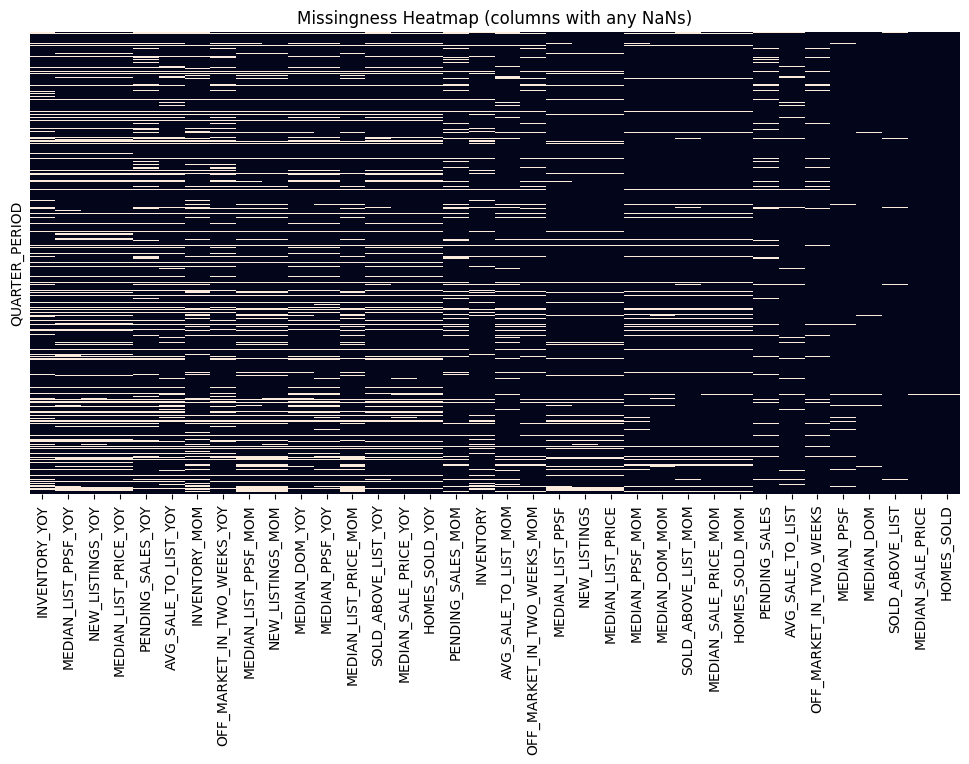

In [13]:
''' Determine Missingness '''

# 1. Compute raw counts and percentages
missing_counts = df.isna().sum()
missing_pct    = (missing_counts / len(df)) * 100

missing_df = pd.concat(
    [missing_counts, missing_pct],
    axis=1,
    keys=['missing_count','missing_percent']
).sort_values('missing_percent', ascending=False)

print(missing_df)

# 2. (Optional) Visualize with a heatmap of the worst offenders
#    — display only columns with >0% missing
cols_with_na = missing_df[missing_df.missing_count > 0].index.tolist()
plt.figure(figsize=(12, 6))
sns.heatmap(
    df[cols_with_na].isna(),
    cbar=False,
    yticklabels=False
)
plt.title("Missingness Heatmap (columns with any NaNs)")
plt.show()

In [18]:
'''
What We did here?

    1. Computes missingness and drops any column with >20% NaNs

    2. Identifies true metric columns (excluding IDs/time fields)

    3. Converts a PeriodIndex to timestamps for interpolation

    4. Imputes each metric per ZIP via time-based interpolation + forward/backward fill

    5. Reports remaining gaps, then drops any metrics still >5% missing

    6. Fills the final stragglers with each column’s global median

    7. Outputs a final sanity check confirming zero missing values
'''

# 1. Compute missingness across all columns
def compute_missing(df):
    miss = df.isna().sum().rename('count')
    pct  = (df.isna().mean()*100).rename('percent')
    return pd.concat([miss, pct], axis=1).sort_values('percent', ascending=False)

missing = compute_missing(df)

# 2. Drop features with >20% missing values
to_drop = missing[missing['percent'] > 20].index.tolist()
if to_drop:
    df = df.drop(columns=to_drop)
print(f"Dropped columns (>20% missing): {to_drop}")

# 3. Identify numeric metric columns for imputation
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
exclude = {
    'YEAR','QUARTER','PERIOD_DURATION',
    'PROPERTY_TYPE_ID','REGION_TYPE_ID',
    'PARENT_METRO_REGION_METRO_CODE','STATE_CODE'
}
metric_cols = [c for c in numeric_cols if c not in exclude]

# 4. Ensure index is timestamp for time-based interpolation
if hasattr(df.index, 'to_timestamp'):
    df.index = df.index.to_timestamp()

# 5. Impute each metric within its ZIP group using interpolation + ffill/bfill
def impute_series(s):
    return s.interpolate(method='time').ffill().bfill()

for col in metric_cols:
    df[col] = df.groupby('ZIP')[col].transform(impute_series)

# 6. Final check: identify any remaining missing values
missing_after = compute_missing(df)
remaining = missing_after['count'].sum()
print("Remaining missing by column (>0):")
print(missing_after[missing_after['count'] > 0])

# 7. Drop any metrics still >5% missing, then fill remainder with column median
to_drop_after = missing_after[missing_after['percent'] > 5].index.tolist()
if to_drop_after:
    df = df.drop(columns=to_drop_after)
    print(f"Dropped after-imputation cols (>5% missing): {to_drop_after}")

for col in metric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# 8. Final sanity check
final_missing = df.isna().sum().sum()
print(f"Total missing values after final fill: {final_missing}")

Dropped columns (>20% missing): []
Remaining missing by column (>0):
Empty DataFrame
Columns: [count, percent]
Index: []
Total missing values after final fill: 0


In [19]:
df.shape

(1069710, 45)

In [23]:
'''Find Outliers and perform winsorization'''

# List of key columns to screen
key_cols = [
    'MEDIAN_SALE_PRICE',   # actual transaction price
    'MEDIAN_LIST_PRICE',   # asking price
    'MEDIAN_PPSF',         # price per sq ft
    'MEDIAN_DOM',          # days on market
    'INVENTORY',           # available supply
    'AVG_SALE_TO_LIST',    # sale/list ratio
    'NEW_LISTINGS',        # flow of new inventory
    'PENDING_SALES'        # sales about to close
]

for col in key_cols:
    # 1. Compute IQR bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # 2. Flag extreme values
    df[f'{col}_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)

    # 3. Winsorize: cap values to the bounds
    df[col] = df[col].clip(lower_bound, upper_bound)

# 4. Quick summary of how many outliers were flagged
outlier_summary = {col: int(df[f'{col}_outlier'].sum()) for col in key_cols}
print("Outliers flagged per metric:", outlier_summary)


Outliers flagged per metric: {'MEDIAN_SALE_PRICE': 0, 'MEDIAN_LIST_PRICE': 32491, 'MEDIAN_PPSF': 35642, 'MEDIAN_DOM': 0, 'INVENTORY': 0, 'AVG_SALE_TO_LIST': 28540, 'NEW_LISTINGS': 59284, 'PENDING_SALES': 68485}


In [24]:
df.shape

(1069710, 53)

In [25]:
df.head()

,PERIOD_BEGIN,PERIOD_END,PERIOD_DURATION,REGION_TYPE,REGION_TYPE_ID,STATE,STATE_CODE,PROPERTY_TYPE,PROPERTY_TYPE_ID,MEDIAN_SALE_PRICE,MEDIAN_SALE_PRICE_MOM,MEDIAN_SALE_PRICE_YOY,MEDIAN_LIST_PRICE,MEDIAN_LIST_PRICE_MOM,MEDIAN_PPSF,MEDIAN_PPSF_MOM,MEDIAN_PPSF_YOY,MEDIAN_LIST_PPSF,MEDIAN_LIST_PPSF_MOM,HOMES_SOLD,HOMES_SOLD_MOM,HOMES_SOLD_YOY,PENDING_SALES,PENDING_SALES_MOM,NEW_LISTINGS,NEW_LISTINGS_MOM,INVENTORY,INVENTORY_MOM,MEDIAN_DOM,MEDIAN_DOM_MOM,MEDIAN_DOM_YOY,AVG_SALE_TO_LIST,AVG_SALE_TO_LIST_MOM,AVG_SALE_TO_LIST_YOY,SOLD_ABOVE_LIST,SOLD_ABOVE_LIST_MOM,SOLD_ABOVE_LIST_YOY,OFF_MARKET_IN_TWO_WEEKS,OFF_MARKET_IN_TWO_WEEKS_MOM,OFF_MARKET_IN_TWO_WEEKS_YOY,PARENT_METRO_REGION,PARENT_METRO_REGION_METRO_CODE,ZIP,YEAR,QUARTER,MEDIAN_SALE_PRICE_outlier,MEDIAN_DOM_outlier,INVENTORY_outlier,MEDIAN_LIST_PRICE_outlier,MEDIAN_PPSF_outlier,AVG_SALE_TO_LIST_outlier,NEW_LISTINGS_outlier,PENDING_SALES_outlier
QUARTER_PERIOD,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-01,2019-05-01,2019-07-31,90,zip code,2,California,CA,Multi-Family (2-4 Unit),4,655500.0,0.077239,0.197260,600000.0,-0.157895,310.091743,-0.176327,0.673646,302.752294,0.052174,3.0,0.500000,2.000000,2.0,0.000000,3.0,0.500000,2.0,1.000000,27.0,-51.5,-42.0,1.041624,0.025438,0.044356,1.000000,0.000000,1.000000,0.500000,0.00000,0.215278,"San Diego, CA",41740,92173,2019,2,False,False,False,False,False,False,False,False
2023-01-01,2023-01-01,2023-03-31,90,zip code,2,Illinois,IL,Single Family Residential,6,169000.0,0.011976,0.229091,179900.0,0.000000,90.167454,-0.011498,0.025614,104.651163,0.054884,25.0,-0.074074,-0.137931,29.0,0.318182,25.0,0.190476,12.0,0.090909,32.5,7.5,-48.5,0.967367,-0.011181,-0.021441,0.120000,-0.102222,-0.121379,0.275862,-0.04232,0.241379,"Peoria, IL",37900,61523,2023,1,False,False,False,False,False,False,False,False
2015-07-01,2015-09-01,2015-11-30,90,zip code,2,Florida,FL,Multi-Family (2-4 Unit),4,59000.0,-0.432692,-0.796552,169500.0,-0.053073,76.129032,-0.070621,-0.029749,176.748885,-0.084018,1.0,-0.500000,0.000000,3.0,0.000000,28.0,0.333333,1.0,0.000000,75.0,31.5,-252.0,0.907692,-0.043152,-0.058974,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,"Jacksonville, FL",27260,32207,2015,3,False,False,False,False,False,False,False,False
2020-01-01,2020-01-01,2020-03-31,90,zip code,2,West Virginia,WV,Townhouse,13,185000.0,-0.028871,0.097923,208112.5,-0.051663,110.451949,-0.164439,0.117144,113.525048,0.000000,8.0,0.000000,3.000000,8.0,0.000000,12.0,0.500000,16.0,0.142857,237.5,80.5,185.5,0.984259,0.002674,0.038150,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,"Morgantown, WV",34060,26501,2020,1,False,False,False,False,False,False,False,False
2016-10-01,2016-12-01,2017-02-28,90,zip code,2,South Carolina,SC,All Residential,-1,148857.5,0.004335,0.103466,145900.0,0.009727,98.707710,-0.009027,0.198594,95.229839,-0.001100,44.0,0.333333,0.333333,44.0,0.333333,57.0,0.140000,108.0,-0.018182,154.5,-6.5,-23.5,0.971145,0.000952,0.026631,0.159091,0.037879,0.007576,0.000000,0.00000,0.000000,"Myrtle Beach, SC",34820,29569,2016,4,False,False,False,False,False,False,False,False


In [27]:
''' Ensure ZIP codes are zero-padded five-digit strings'''

df['ZIP'] = df['ZIP'].astype(str).str.zfill(5)

# 1. Check that all ZIPs are strings of length 5
lengths = df['ZIP'].str.len().unique()
print("Unique ZIP code lengths:", lengths)

# 2. Assert that every ZIP matches exactly five digits
import re
pattern = re.compile(r'^\d{5}$')
invalid = df.loc[~df['ZIP'].apply(lambda x: bool(pattern.match(x))), 'ZIP'].unique()
print("Invalidly formatted ZIPs (should be none):", invalid)

# 3. Optional: raise an error if any bad ZIPs remain
assert len(invalid) == 0, f"Found improperly formatted ZIP codes: {invalid}"

Unique ZIP code lengths: [5]
Invalidly formatted ZIPs (should be none): []


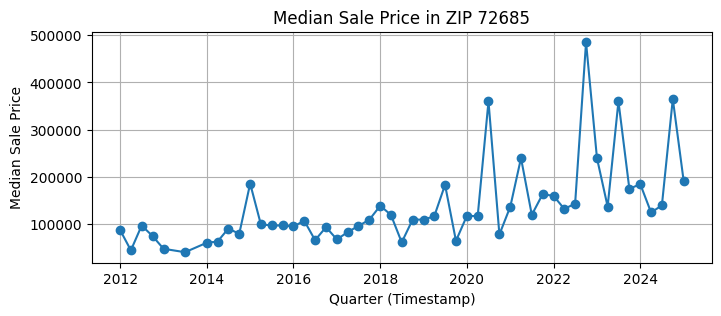

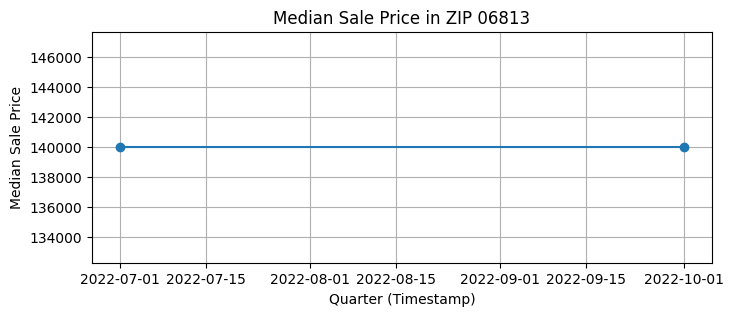

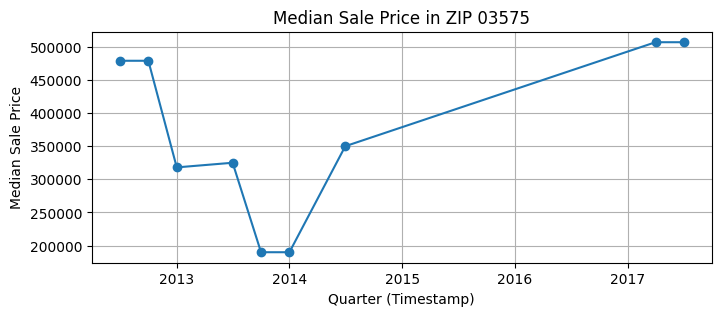

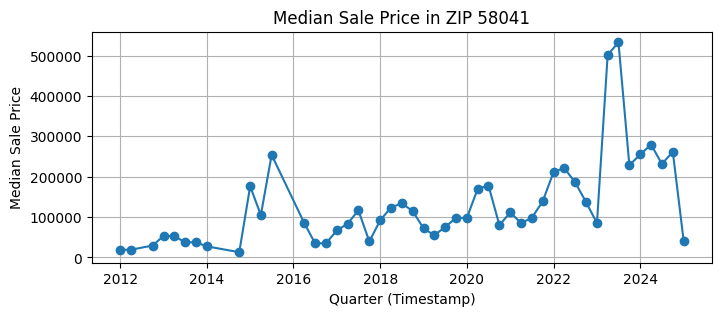

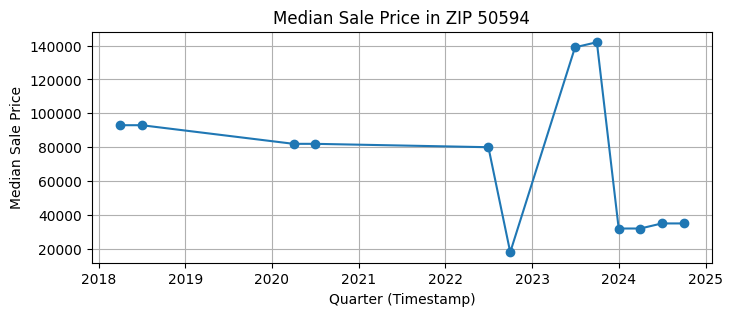

Example ZIPs with at least one price decrease: ['00501', '01001', '01002', '01003', '01005', '01007', '01008', '01009', '01010', '01011']
Example ZIPs with >50% QoQ jump: ['00501', '01001', '01002', '01003', '01005', '01007', '01008', '01009', '01010', '01011']


In [29]:
'''
Basic sanity checks:
Spot‐check a few ZIP codes over time. Does price always go up? Are there obvious data entry errors?
'''

# 1. Pick 5 sample ZIPs at random (or specify your own list)
sample_zips = df['ZIP'].drop_duplicates().sample(5, random_state=42).tolist()

# 2. Plot median sale price over time for each sample ZIP
for zip_code in sample_zips:
    series = df.loc[df['ZIP'] == zip_code, 'MEDIAN_SALE_PRICE'].sort_index()
    plt.figure(figsize=(8, 3))
    plt.plot(series.index, series.values, marker='o')
    plt.title(f'Median Sale Price in ZIP {zip_code}')
    plt.xlabel('Quarter (Timestamp)')
    plt.ylabel('Median Sale Price')
    plt.grid(True)
    plt.show()

# 3. Check which ZIPs ever saw a price decrease
monotonic = (
    df
    .sort_index()
    .groupby('ZIP')['MEDIAN_SALE_PRICE']
    .apply(lambda s: s.is_monotonic_increasing)
)
# List a few that dipped
dipped = monotonic[~monotonic].index.tolist()[:10]
print("Example ZIPs with at least one price decrease:", dipped)

# 4. Identify ZIPs with extreme quarter-to-quarter jumps (>50%)
def extreme_jumps(s, threshold=0.5):
    return s.pct_change().abs().gt(threshold).any()

jumpy = (
    df
    .sort_index()
    .groupby('ZIP')['MEDIAN_SALE_PRICE']
    .apply(extreme_jumps)
)
print("Example ZIPs with >50% QoQ jump:", jumpy[jumpy].index.tolist()[:10])

In [31]:
''' Save The clean dataset '''

import os

# Ensure the output directory exists
output_dir = 'data/cleaned_data'
os.makedirs(output_dir, exist_ok=True)

# Save the cleaned DataFrame to CSV
output_path = os.path.join(output_dir, 'cleaned_dataset.csv')
df.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")


Cleaned dataset saved to: data/cleaned_data/cleaned_dataset.csv


## Conclusion

At the end of this cleaning pipeline, we have produced a high-quality, fully imputed, and outlier-controlled dataset for ZIP-level real-estate analysis. All date fields are properly typed and indexed by quarter, ZIP codes are uniformly formatted, and key numeric features contain no missing values or extreme artifacts. We have also flagged and winsorized outliers to mitigate undue influence from low-volume or anomalous observations. With this foundation in place, the data is now ready for:

- EDA
- Scaling and normalization  
- Feature engineering (e.g. affordability indices, liquidity measures)  
- Exploratory visualizations of price and market trends  
- Predictive modeling or ranking algorithms to identify the best ZIP codes for first-time buyers  

Proceed to the next notebook section for exploratory data analysis and model development.
